In [1]:
from compare_simulators import CalculatorComparator
from population_simulator import CerfaPopulationSimulator
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
comparator = CalculatorComparator()
test_cases = CerfaPopulationSimulator().generate_test_cases(100)
r_openfisca, r_impotsgouv = comparator.openfisca_vs_impotsgouv(test_cases)


Generating test cases:
{'year': 2014, '0DA': 1955, '1AJ': 24152.703294162537}
{'year': 2014, '0DA': 1939, '1AJ': 43211.99358631694}
{'year': 2014, '0DA': 1982, '1AJ': 41129.20501543228}
{'year': 2014, '0DA': 1943, '1AJ': 29491.299140089297}
{'year': 2014, '0DA': 1958, '1AJ': 0}
{'year': 2014, '0DA': 1977, '1AJ': 0}
{'year': 2014, '0DA': 1972, '1AJ': 17431.910460244086}
{'year': 2014, '0DA': 1933, '1AJ': 0}
{'year': 2014, '0DA': 1971, '1AJ': 32229.593805146178}
{'year': 2014, '0DA': 1967, '1AJ': 0}
{'year': 2014, '0DA': 1994, '1AJ': 3290.4084829706626}
{'year': 2014, '0DA': 1975, '1AJ': 13699.91150780458}
{'year': 2014, '0DA': 1932, '1AJ': 29617.100802357636}
{'year': 2014, '0DA': 1949, '1AJ': 12876.764154362296}
{'year': 2014, '0DA': 1990, '1AJ': 5558.221822414076}
{'year': 2014, '0DA': 1956, '1AJ': 28109.367634769183}
{'year': 2014, '0DA': 1988, '1AJ': 41478.085311841445}
{'year': 2014, '0DA': 1980, '1AJ': 11390.577044054477}
{'year': 2014, '0DA': 1958, '1AJ': 0}
{'year': 2014, '0DA':

In [5]:
x, r1, r2, diff, combined, colors = comparator.compare_results(test_cases, '1AJ', r_openfisca, 'irpp', r_impotsgouv, 'IINET (Total de votre imposition )')

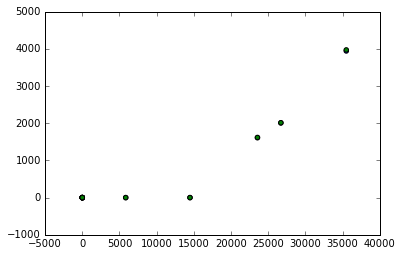

In [14]:
plt.scatter(x + x, combined, c=colors)

In [ ]:
plt.scatter(x, diff)